# Laboratory Exercise: Click-Through Rate (CTR) Prediction for Ad Placements

## Introduction

In this laboratory exercise, you will build a **binary classification model** that predicts whether a given **ad placement on a webpage will be clicked or not**. Each example in the dataset represents a single ad impression with a set of features describing the context of the placement (e.g. page, position, user and ad attributes). The target variable is a binary label indicating whether the ad was clicked.

---

## Problem Definition

- **Task:** Binary classification
- **Target column:** `is_click`
- **Goal:** Predict whether an ad placement will be clicked (`1`) or not (`0`)

You will work with a provided dataset (`dataset.csv`) and implement a complete **machine learning training pipeline** using PyTorch.

---

## Tasks Overview

You are required to implement the following components:

1. **Data Preparation**
   - Load the `dataset.csv` file
   - Separate features from the target column `is_click`
   - Split the data into training, validation, and test sets
   - Apply any required preprocessing

2. **Dataset Class**
   - Implement an `AdsDataset` class compatible with PyTorch’s `DataLoader`

3. **Model Building**
   - Implement a `build_model` function that returns a neural network for binary classification

4. **Training and Evaluation**
   - Implement:
     - `train_one_epoch`
     - `evaluate`
     - `test`
   - Train the model for a fixed number of epochs
   - Track training loss, validation loss, and validation accuracy for each epoch

5. **Visualization**
   - Plot:
     - Training loss vs. epochs
     - Validation loss vs. epochs
     - Validation accuracy vs. epochs

6. **Testing and Reporting**
   - Evaluate the final model on the test dataset
   - Generate a **classification report** (precision, recall, F1-score)

---

## Model Comparison Requirement

You must design and train **two different model configurations**, for example:
- Different network depths or widths
- Different activation functions
- Different regularization strategies (e.g. dropout)

For **each model**, you must:
- Train it for the same number of epochs
- Plot training and validation metrics
- Evaluate it on the test set

# ⚠️ **Performance Constraint:**

At least **one of your models must achieve a minimum F1-score of 66% for *both* classes** on the test dataset.

Reaching this performance level will **not be possible by blindly training a model with default settings**. You are expected to **carefully examine the properties of the dataset** and recall a key concept discussed in class that can significantly affect the performance of binary classifiers in real-world scenarios.

Identifying and addressing this issue is an **essential part of the exercise** and will be reflected in the final evaluation.


## Dataset Description

The dataset contains information about individual **ad placements shown to users on a webpage**.
Each row represents a single ad impression together with contextual, user-related, and placement-related features, as well as a binary label indicating whether the ad was clicked.

### Feature Descriptions

- **product**
  The product being advertised. Categorical feature.

- **activity**
  The primary activity the user was engaged in at the time the ad was shown (e.g. texting, browsing, reading).
  Categorical feature.

- **webpage**
  The type of the webpage on which the advertisement was displayed.
  Categorical feature.

- **position**
  The position of the ad on the webpage (e.g. top, middle, bottom).
  Categorical feature.

- **country**
  The country associated with the user viewing the advertisement.
  Categorical feature.

- **session_id**
  A unique identifier for the user session in which the ad was shown.

- **gender**
  The gender of the user viewing the advertisement.
  Categorical feature.

- **age_level**
  A numerical representation of the user’s age group or age category level.
  Numerical feature.

- **user_depth**
  A numerical indicator of the user’s engagement depth or experience level on the platform.
  Higher values typically indicate more experienced or frequent users.

- **previously_shown_ad**
  Binary indicator showing whether the user has previously been shown the same or a similar advertisement:
  - `0` — No
  - `1` — Yes

- **is_click**
  The target variable indicating whether the ad was clicked:
  - `0` — Not clicked
  - `1` — Clicked

In [14]:
from typing import Tuple

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv("dataset.csv")
df

,product,activity,webpage,position,country,session_id,gender,age_level,user_depth,previously_shown_ad,is_click
0,Plastic Bubble filled with Water - Fidget Toy,Texting,Web Page About Warehouses,Middle,Spain,140690,Female,4.0,3.0,0,0
1,Nails Polish For French Nails (Cosmetics),Texting,Web Page About Warehouses,Bottom,Greece,464848,Male,3.0,3.0,1,0
2,Plastic Bubble filled with Water - Fidget Toy,Sending Reels,Web Page About Crypto,Bottom,Greece,90569,Male,2.0,3.0,1,0
3,War Helmet to keep you safe in the night (Tools),Sending Reels,Web Page About Crypto,Bottom,Italy,17583,Female,3.0,3.0,0,0
4,Plastic Bubble filled with Water - Fidget Toy,*CONFESSING* online crimes,Web Page About Warehouses,Bottom,Italy,461128,Male,4.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
338157,Nails Polish For French Nails (Cosmetics),Writing Project Documentation,Web Page About Blue-Green Eyes,Middle,Spain,393785,Male,3.0,3.0,0,0
338158,Plastic Bubble filled with Water - Fidget Toy,*CONFESSING* online crimes,Web Page About Warehouses,Top,Greece,292866,Male,3.0,3.0,1,0
338159,MacBook Air M4 and Ipad bought almost 1 month ...,Writing Project Documentation,Web Page About Blue-Green Eyes,Top,Greece,583588,Male,4.0,3.0,0,0
338160,Nails Polish For French Nails (Cosmetics),Writing Project Documentation,Web Page About Blue-Green Eyes,Middle,Greece,198389,Female,4.0,3.0,1,0


In [16]:
def prepare_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame,pd.DataFrame, pd.DataFrame, pd.DataFrame, ColumnTransformer]:
    """
    Prepare the ad placement dataset for training and evaluation.

    The input DataFrame contains feature columns describing an ad placement
    and a binary target column "is_click" indicating whether the ad was clicked.

    Steps (you MUST follow these steps):
    1. Drop the identifier column: "session_id".
    2. Separate features (X) and target (y), where the target column is "is_click".
    3. One-hot encode all the categorical columns using a ColumnTransformer:
       - Use OneHotEncoder(handle_unknown="ignore", drop="first")
       - Leave all other (numerical) columns unchanged (passthrough).
    4. Fit the preprocessor.
    5. Split the data in TWO stages (keep stratification):
       - First split into train and test:
            * test_size = 0.2
            * random_state = 42
            * stratify = y
       - Then split the training part into train and validation:
            * test_size = 0.2   (this is 20% of the training set)
            * random_state = 42
            * stratify = y_train
    6. Return:
         X_train, X_val, X_test, y_train, y_val, y_test, preprocessor

    Notes:
    - The returned X arrays should be fully numeric and suitable for PyTorch.
    """

    df.drop(columns=["session_id"], axis=1, inplace=True)
    X, y = df.drop(columns=["is_click"]), df["is_click"]
    transformer = ColumnTransformer(transformers=[
        ("cat", OneHotEncoder(drop="first", sparse_output=False), ["product", "activity", "webpage", "position", "country", "gender"])],
        remainder="passthrough")
    preprocessor = transformer.fit_transform(X)
    y_array = y.values

    X_train_full, X_test, y_train_full, y_test = train_test_split(
        preprocessor,
        y_array,
        test_size=0.2,
        random_state=42,
        stratify=y_array,
    )


    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full,
        y_train_full,
        test_size=0.2,
        random_state=42,
        stratify=y_train_full,
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test, preprocessor


In [17]:
class AdsDataset(Dataset):
    """
    A PyTorch Dataset for the ad click prediction task.

    Each sample consists of:
    - a feature vector representing an ad placement
    - a binary label indicating whether the ad was clicked

    Requirements:
    - __init__(self, X, y):
        * X: numpy array of features
        * y: array-like of binary labels (0 or 1)
        * Store:
            - X as a float32 tensor
            - y as a float32 tensor with shape (N, 1)
    - __len__(self):
        * Return the number of samples
    - __getitem__(self, idx):
        * Return (X[idx], y[idx])
    """
    def __init__(self,X,y):
        super().__init__()

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [18]:
def train_one_epoch(model: nn.Module,
                    train_loader: DataLoader,
                    criterion,
                    optimizer) -> float:
    """
    Train the model for ONE epoch on the training dataset.

    Requirements:
    - Set the model to training mode using model.train()
    - Iterate over batches from train_loader
    - For each batch:
        * Compute model outputs
        * Compute the loss using the provided criterion
        * Zero the gradients
        * Perform backpropagation
        * Update model parameters using the optimizer
    - Accumulate the training loss over all batches
    - Return the average training loss as a float
      (total loss divided by the number of batches)
    """
    model.train()

    batches = 0
    losses = []

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        batches += 1
    return sum(losses) / batches

In [19]:
from sklearn.metrics import accuracy_score


def evaluate(model: nn.Module,
             val_loader: DataLoader,
             criterion: nn.Module) -> Tuple[float ,float]:
    """
    Evaluate the model on the validation dataset.

    Requirements:
    - Set the model to evaluation mode using model.eval()
    - Disable gradient computation using torch.no_grad()
    - Iterate over batches from val_loader
    - For each batch:
        * Compute model outputs
        * Compute and accumulate validation loss
        * Convert model outputs to probabilities
        * Convert probabilities to binary labels using a threshold of 0.5
        * Collect predicted labels and true labels
    - Compute validation accuracy over the entire validation set
    - Return:
        - validation accuracy (float)
        - validation loss (float)
    """
    model.eval()

    all_true_labels = []
    all_predicted_labels = []
    total_loss = 0.0
    total_batches = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_batches += 1
            predictions = (probs >= 0.5).float()
            all_predicted_labels.extend(predictions.cpu().numpy().flatten())
            all_true_labels.extend(labels.cpu().numpy().flatten())

    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    avg_loss = total_loss / total_batches            

    return float(accuracy), float(avg_loss)

In [20]:
def test(model: nn.Module,
         test_loader: DataLoader) -> tuple[Tensor, Tensor]:
    """
    Evaluate the trained model on the test dataset.

    Requirements:
    - Set the model to evaluation mode using model.eval()
    - Disable gradient computation using torch.no_grad()
    - Iterate over batches from test_loader
    - For each batch:
        * Compute model outputs
        * Convert outputs to probabilities
        * Convert probabilities to binary labels using a threshold of 0.5
        * Collect all predicted labels and true labels
    - Return:
        - Tensor of predicted labels
        - Tensor of true labels

    These outputs will be used to compute a classification report.
    """
    model.eval()
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)

            probs = torch.sigmoid(outputs)

            predictions = (probs >= 0.5).float()

            all_predicted_labels.extend(predictions.cpu().numpy().flatten())
            all_true_labels.extend(labels.cpu().numpy().flatten())

    all_predicted_labels = torch.tensor(all_predicted_labels)
    all_true_labels = torch.tensor(all_true_labels)

    return all_predicted_labels, all_true_labels

In [21]:
def build_model_1(input_dim: int) -> nn.Module:
    """
    Build and return a PyTorch neural network for binary ad click prediction.

    Requirements:
    - Use nn.Sequential to define the model
    - The model must accept input vectors of size input_dim
    - The final output must be a single value representing the predicted
      probability that an ad is clicked
    - The final layer MUST have exactly 1 neuron

    Note:
    - You may include additional layers, activation functions, normalization,
      or regularization techniques
    - The output of the model must be suitable for binary classification
    """
    model = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid()
    )
    return model

In [22]:
def build_model_2(input_dim: int) -> nn.Module:
    """
    Build and return a PyTorch neural network for binary ad click prediction.

    Requirements:
    - Use nn.Sequential to define the model
    - The model must accept input vectors of size input_dim
    - The final output must be a single value representing the predicted
      probability that an ad is clicked
    - The final layer MUST have exactly 1 neuron

    Note:
    - You may include additional layers, activation functions, normalization,
      or regularization techniques
    - The output of the model must be suitable for binary classification
    """
    model = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid()
    )
    return model

### Build the models

In [23]:
X_train, X_val, X_test, y_train, y_val, y_test, preprocessor = prepare_data(df)

input_dim = X_train.shape[1]

model = build_model_1(input_dim)
model_2 = build_model_2(input_dim)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.001)

print(model)
print(model_2)

Sequential(
  (0): Linear(in_features=37, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)
Sequential(
  (0): Linear(in_features=37, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)


### Train model 1

In [24]:
train_ds = AdsDataset(X_train, y_train)
val_ds = AdsDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

len(train_ds), len(val_ds)

(216423, 54106)

In [26]:
epochs = 10
train_losses_1 = []
val_losses_1 = []
val_accuracies_1 = []

for epoch in range(epochs):

    # Call all required functions and store the computed metrics
    # (training loss, validation loss, and validation accuracy).

    train_loss = train_one_epoch(model,train_loader,criterion,optimizer)
    val_acc, val_loss = evaluate(model, val_loader, criterion)

    train_losses_1.append(train_loss)
    val_accuracies_1.append(val_acc)
    val_losses_1.append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs} | Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f}")

Epoch 1/10 | Train loss: 0.2460 | Val acc: 0.0676
Epoch 2/10 | Train loss: 0.2457 | Val acc: 0.0676
Epoch 3/10 | Train loss: 0.2456 | Val acc: 0.0676
Epoch 4/10 | Train loss: 0.2454 | Val acc: 0.0676
Epoch 5/10 | Train loss: 0.2453 | Val acc: 0.0676
Epoch 6/10 | Train loss: 0.2451 | Val acc: 0.0676
Epoch 7/10 | Train loss: 0.2451 | Val acc: 0.0676
Epoch 8/10 | Train loss: 0.2449 | Val acc: 0.0676
Epoch 9/10 | Train loss: 0.2449 | Val acc: 0.0676
Epoch 10/10 | Train loss: 0.2449 | Val acc: 0.0676


### Train model 2

In [28]:
epochs = 10
train_losses_2 = []
val_losses_2 = []
val_accuracies_2 = []

for epoch in range(epochs):

    # Call all required functions and store the computed metrics
    # (training loss, validation loss, and validation accuracy).

    train_loss = train_one_epoch(model, train_loader, criterion, optimizer_2)
    val_acc, val_loss = evaluate(model, val_loader, criterion)

    train_losses_2.append(train_loss)
    val_losses_2.append(val_loss)
    val_accuracies_2.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs} | Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f}")

Epoch 1/10 | Train loss: 0.2445 | Val acc: 0.0676
Epoch 2/10 | Train loss: 0.2444 | Val acc: 0.0676
Epoch 3/10 | Train loss: 0.2444 | Val acc: 0.0676
Epoch 4/10 | Train loss: 0.2444 | Val acc: 0.0676
Epoch 5/10 | Train loss: 0.2444 | Val acc: 0.0676
Epoch 6/10 | Train loss: 0.2444 | Val acc: 0.0676
Epoch 7/10 | Train loss: 0.2444 | Val acc: 0.0676
Epoch 8/10 | Train loss: 0.2444 | Val acc: 0.0676
Epoch 9/10 | Train loss: 0.2444 | Val acc: 0.0676
Epoch 10/10 | Train loss: 0.2444 | Val acc: 0.0676


### Visualize

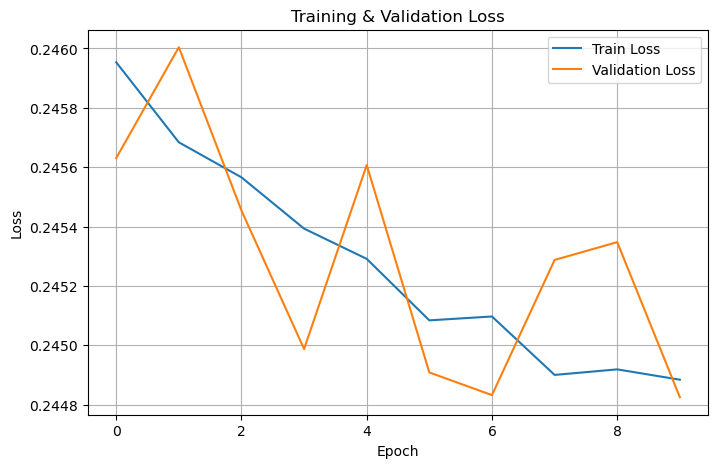

In [29]:
# Visualize training and validation loss on the same plot, and visualize the validation accuracy across epochs.
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses_1, label="Train Loss")
plt.plot(val_losses_1, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

### Evaluate

In [ ]:
# Evaluate on the test dataset